In [ ]:
pip uninstall ipython-sql

Found existing installation: ipython-sql 0.5.0
Uninstalling ipython-sql-0.5.0:
  Would remove:
    /usr/local/lib/python3.10/dist-packages/ipython_sql-0.5.0.dist-info/*
    /usr/local/lib/python3.10/dist-packages/sql/*
Proceed (Y/n)? Y
  Successfully uninstalled ipython-sql-0.5.0


In [ ]:
pip install wrds

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 32.6 MB/s eta 0:00:00


In [ ]:
# Importing necessary libraries

# Interface to the Wharton Research Data Services (WRDS) database
import wrds

# Library for data manipulation and analysis
import pandas as pd


In [ ]:
# Establishing a connection to the Wharton Research Data Services (WRDS) database
conn = wrds.Connection()

Enter your WRDS username [root]:manalteto
Enter your password:··········
WRDS recommends setting up a .pgpass file.
Create .pgpass file now [y/n]?: n
You can create this file yourself at any time with the create_pgpass_file() function.
Loading library list...
Done


In [ ]:
# Define a list of ticker symbols for the Telfer Capital Fund's stocks
ticker_list = [
    'ZIN',   # BMO Equal Weight Industrials Index ETF
    'KKR',   # KKR & Co. Inc.
    'VGT',   # Vanguard World Fund - Vanguard Information Technology ETF
    'MSFT',  # Microsoft Corporation
    'BLK',   # BlackRock, Inc.
    'XFN',   # iShares S&P/TSX Capped Financials Index ETF
    'MCK',   # McKesson Corporation
    'PLC',   # Park Lawn Corporation
    'V',     # Visa Inc.
    'FENY',  # Fidelity Covington Trust - Fidelity MSCI Energy Index ETF
    'MNST',  # Monster Beverage Corporation
    'CIGI',  # Colliers International Group Inc.
    'TOI',   # Topicus.com Inc.
    'TTWO',  # Take-Two Interactive Software, Inc.
    'JNJ',   # Johnson & Johnson
    'MFC',   # Manulife Financial Corporation
    'XMA',   # iShares S&P/TSX Capped Materials Index ETF
    'VCR',   # Vanguard World Fund - Vanguard Consumer Discretionary ETF
    'BEP.UN',# Brookfield Renewable Partners L.P.
    'DD',    # DuPont de Nemours, Inc.
    'TPZ',   # Topaz Energy Corp.
    'BNS',   # The Bank of Nova Scotia
    'SU',    # Suncor Energy Inc.
    'DOW',   # Dow Inc.
    'IYZ',   # iShares Trust - iShares U.S. Telecommunications ETF
    'PINS',  # Pinterest, Inc.
    'CTVA',  # Corteva, Inc.
    'FTS',   # Fortis Inc.
    'BEPC',  # Brookfield Renewable Corporation
]


In [ ]:
# Convert the list of ticker symbols into a string format suitable for SQL queries.
# The join() method is used to concatenate the tickers with "','",
# which prepares the list for the IN clause of an SQL query.

ticker_string = "','".join(ticker_list)

In [ ]:
# Query the WRDS database to map ticker symbols to their corresponding CUSIP numbers.
# The SQL query selects the ticker and cusip columns from the crsp.stocknames table
# and filters the results to only include rows where the ticker is in the provided list of tickers.

mapping_data = conn.raw_sql(f"""
    SELECT ticker, cusip
    FROM crsp.stocknames
    WHERE ticker IN ('{ticker_string}')
""")

In [ ]:
# Query the WRDS database to fetch stock data for the mapped CUSIP numbers.
# The SQL query selects the cusip, date, prc, ret, and shrout columns from the crsp.msf table.
# It filters the results to only include rows where the cusip is in the provided list of CUSIP numbers
# and the date is on or after '2021-12-31'.

cusip_string = "','".join(mapping_data['cusip'].tolist())
data = conn.raw_sql(f"""
    SELECT cusip, date, prc, ret, shrout
    FROM crsp.msf
    WHERE cusip IN ('{cusip_string}')
    AND date >= '2021-12-31'
""")

In [ ]:
# Display first 5 rows
data.head(5)

,cusip,date,prc,ret,shrout
0,59491810,2021-12-31,336.320007,0.017333,7507980.0
1,59491810,2022-01-31,310.980011,-0.075345,7496866.0
2,59491810,2022-02-28,298.790009,-0.037205,7496866.0
3,59491810,2022-03-31,308.309998,0.031862,7483000.0
4,59491810,2022-04-29,277.519989,-0.099867,7479033.0


In [ ]:
# Import necessary libraries
import pandas as pd

# Define URLs for Fama-French 3-factor and Momentum factor data
# These datasets are available on Ken French's website and are commonly used in financial research.
url_3factor = "https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Research_Data_Factors_daily_CSV.zip"
url_mom = "https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Momentum_Factor_daily_CSV.zip"

# Fetch the Fama-French 3-factor and Momentum factor data directly from the URLs
# The data is in zipped CSV format, so we use pandas' read_csv function with the 'compression' parameter set to 'zip'.
# We also skip the initial rows that contain descriptions rather than actual data.
fama_french_3factor = pd.read_csv(url_3factor, skiprows=3, compression='zip')
momentum_data = pd.read_csv(url_mom, skiprows=13, compression='zip')

# Clean the data:
# - Rename columns for clarity and consistency
# - Drop rows with missing values to ensure data integrity
fama_french_3factor.columns = ['date', 'market', 'smb', 'hml', 'rf']
fama_french_3factor = fama_french_3factor.dropna()

momentum_data.columns = ['date', 'mom']
momentum_data = momentum_data.dropna()

# Convert the 'date' columns to a standard datetime format
# This makes date-based operations easier and more consistent.
fama_french_3factor['date'] = pd.to_datetime(fama_french_3factor['date'], format='%Y%m%d')
momentum_data['date'] = pd.to_datetime(momentum_data['date'], format='%Y%m%d')

# Merge the two datasets on the 'date' column
# This creates a single dataframe with all four factors (market, smb, hml, momentum) for each date.
fama_french_data = pd.merge(fama_french_3factor, momentum_data, on='date', how='inner')

# Filter the merged data to only include dates from '2021-12-31' to '2023-09-30'
# This ensures we're working with a relevant and manageable subset of the data.
fama_french_data = fama_french_data[(fama_french_data['date'] >= '2021-12-31') & (fama_french_data['date'] <= '2023-09-30')]

# Display the first few rows of the merged and filtered dataframe to inspect the data.
print(fama_french_data.head())


            date  market   smb   hml   rf   mom
25046 2021-12-31   -0.31  0.05  0.53  0.0  0.42
25047 2022-01-03    0.73  0.34  0.78  0.0 -1.06
25048 2022-01-04   -0.29 -0.82  3.62  0.0  0.39
25049 2022-01-05   -2.28 -1.46  2.60  0.0 -0.71
25050 2022-01-06    0.00  0.20  1.75  0.0  0.71


<ipython-input-10-fb2a5f87e7c3>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fama_french_3factor['date'] = pd.to_datetime(fama_french_3factor['date'], format='%Y%m%d')


In [ ]:
import pandas as pd
import statsmodels.api as sm  # Importing the statsmodels library for regression analysis

# Convert the 'date' column in the 'data' dataframe to a standard datetime format
# This ensures consistency in date formats across dataframes and facilitates merging.
data['date'] = pd.to_datetime(data['date'])

# Merge the 'data' dataframe with the 'fama_french_data' dataframe based on the 'date' column
# The 'left' join ensures that all dates in the 'data' dataframe are retained, even if they don't have a match in 'fama_french_data'.
merged_data = pd.merge(data, fama_french_data, on='date', how='left')

# Compute the excess return for each stock
# Excess return is the stock's return minus the risk-free rate ('rf'). It represents the return earned above the risk-free rate.
merged_data['excess_return'] = merged_data['ret'] - merged_data['rf']

# Compute expected returns for each stock based on the Carhart four-factor model (Fama-French 3-factor + Momentum)
expected_returns = {}  # Initialize an empty dictionary to store expected returns for each stock (CUSIP)

# Loop through each unique CUSIP (stock identifier) in the merged data
for cusip in merged_data['cusip'].unique():
    # Filter the merged data for the current CUSIP to get data specific to that stock
    stock_data = merged_data[merged_data['cusip'] == cusip]

    # Define the independent variables (factors) and the dependent variable (excess return)
    X = stock_data[['market', 'smb', 'hml', 'mom']]
    y = stock_data['excess_return']

    # Run the OLS regression to estimate the stock's sensitivities (betas) to the four factors
    model = sm.OLS(y, sm.add_constant(X)).fit()

    # Extract the regression coefficients (intercept and betas)
    intercept, market_beta, smb_beta, hml_beta, mom_beta = model.params

    # Compute the expected return for the stock based on the Carhart four-factor model
    # The expected return is the sum of the product of each beta and the mean of its corresponding factor, adjusted for the intercept.
    expected_return = (intercept +
                       market_beta * X['market'].mean() +
                       smb_beta * X['smb'].mean() +
                       hml_beta * X['hml'].mean() +
                       mom_beta * X['mom'].mean())

    # Store the computed expected return in the dictionary with the CUSIP as the key
    expected_returns[cusip] = expected_return


# Convert the expected monthly returns for each stock into a pandas Series for further analysis.
exp_returns = pd.Series(expected_returns)


In [ ]:
# Close Connection
conn.close()

In [ ]:
# Pivot the merged dataset to restructure it for easier analysis.
# The goal is to transform the dataset such that:
# - Each row corresponds to a unique date.
# - Each column corresponds to a unique stock (identified by its CUSIP number).
# - The values in the table represent the excess return of each stock on each date.

returns_data = merged_data.pivot(index='date', columns='cusip', values='excess_return')

# After this transformation:
# - The 'returns_data' DataFrame will have dates as its row indices.
# - Each column will represent a different stock from the Telfer Capital Fund.
# - The values in each cell will indicate the excess return (stock return minus risk-free rate)
#   of a particular stock on a particular date.


In [ ]:
import numpy as np
import scipy.optimize as sco

# Calculate the number of assets (stocks) in the dataset.
num_assets = len(returns_data.columns)

# We've already calculated the expected returns using the Fama-French model in the previous steps.
# Hence, we don't need to use the historical mean returns.
# exp_returns = returns_data.mean() # This line is commented out as it's not needed.

# Calculate the covariance matrix of the returns. This matrix represents how the returns of the assets vary with respect to each other.
cov_matrix = returns_data.cov()

# Define the negative Sharpe ratio function. The Sharpe ratio is a measure of risk-adjusted return.
# We want to maximize the Sharpe ratio, but since optimization functions typically minimize,
# we take the negative of the Sharpe ratio to convert our maximization problem into a minimization one.
def neg_sharpe(weights):
    # Calculate the expected portfolio return as a dot product of weights and expected returns.
    port_return = np.dot(exp_returns, weights)
    # Calculate the portfolio variance.
    port_variance = np.dot(weights.T, np.dot(cov_matrix, weights))
    # Return the negative Sharpe ratio.
    return -port_return / np.sqrt(port_variance)

# Constraints for the optimization: The sum of weights is 1. This means the sum of the proportions of all assets in the portfolio is 100%.
constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})

# Bounds for the optimization: Each weight can take a value between 0 and 1.
bounds = tuple((0, 1) for asset in range(num_assets))

# Initial guess for the optimization: Equally distribute the portfolio across all assets.
initial_guess = [1./num_assets for asset in range(num_assets)]

# Use the 'SLSQP' method to minimize the negative Sharpe ratio, which is equivalent to maximizing the Sharpe ratio.
sol = sco.minimize(neg_sharpe, initial_guess, method='SLSQP', bounds=bounds, constraints=constraints)

# Extract the optimal weights for the assets from the solution.
optimal_weights = sol.x


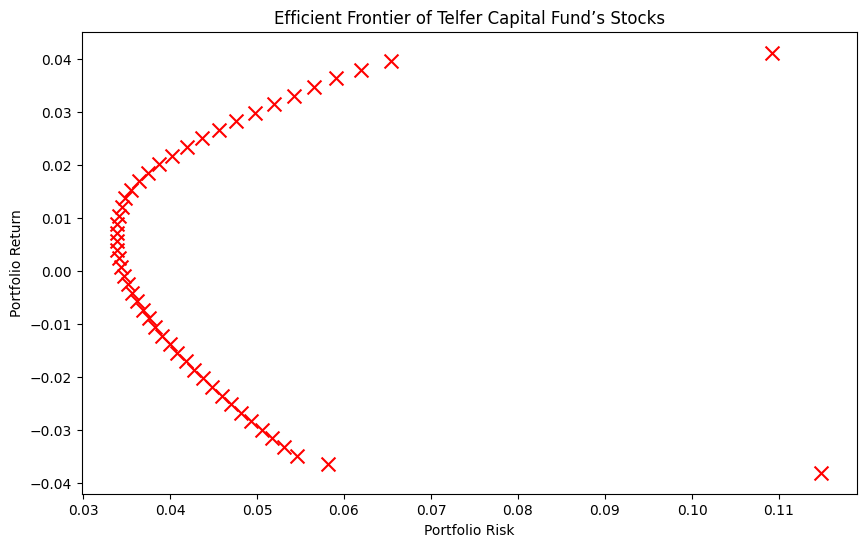

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize as sco

# Define a function to calculate the performance of a portfolio:
def calc_portfolio_perf(weights, mean_returns, cov_matrix):
    # Calculate the expected return of the portfolio given the weights of assets
    portfolio_return = np.dot(mean_returns, weights)
    # Calculate the standard deviation (risk) of the portfolio given the weights of assets
    portfolio_stddev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return portfolio_return, portfolio_stddev

# Define a function to compute the efficient frontier:
def efficient_frontier(mean_returns, cov_matrix, returns_range):
    efficients = []
    for ret in returns_range:
        # Constraints ensure that the portfolio return matches the target return and weights sum to 1
        constraints = ({'type': 'eq', 'fun': lambda w: calc_portfolio_perf(w, mean_returns, cov_matrix)[0] - ret},
                       {'type': 'eq', 'fun': lambda w: np.sum(w) - 1})
        # Minimize the portfolio risk for a given target return
        result = sco.minimize(lambda w: calc_portfolio_perf(w, mean_returns, cov_matrix)[1],
                              [1./num_assets for _ in range(num_assets)],
                              method='SLSQP',
                              bounds=bounds,
                              constraints=constraints)
        efficients.append(result)
    return efficients

# Calculate the covariance matrix of the excess returns
cov_matrix = merged_data.pivot(index='date', columns='cusip', values='excess_return').cov()

# Create a range of target returns between the minimum and maximum expected returns of the assets.
returns_range = np.linspace(exp_returns.min(), exp_returns.max(), 50)

# Calculate efficient portfolios for the range of target returns.
efficients = efficient_frontier(exp_returns, cov_matrix, returns_range)

# Plotting the efficient frontier:
plt.figure(figsize=(10, 6))
# Plot each efficient portfolio as a red 'x' on the graph
plt.scatter([p['fun'] for p in efficients], returns_range, marker='x', color='red', s=100)
plt.title('Efficient Frontier of Telfer Capital Fund’s Stocks')
plt.xlabel('Portfolio Risk')
plt.ylabel('Portfolio Return')
plt.show()


In [ ]:
def calc_portfolio_perf(weights, mean_returns, cov_matrix):
    """
    Calculates the performance of the portfolio based on the given weights.

    Parameters:
    - weights: List of asset weights in the portfolio.
    - mean_returns: Expected returns for each asset.
    - cov_matrix: Covariance matrix of asset returns.

    Returns:
    - portfolio_return: Expected return of the portfolio.
    - portfolio_stddev: Standard deviation (risk) of the portfolio.
    """
    weights = np.array(weights)  # Convert weights to a numpy array for mathematical operations
    portfolio_return = np.dot(mean_returns, weights)
    portfolio_stddev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return portfolio_return, portfolio_stddev

def check_on_frontier(weights, mean_returns, cov_matrix):
    """
    Checks if the portfolio with the given weights is on the efficient frontier.

    Parameters:
    - weights: List of asset weights in the portfolio.
    - mean_returns: Expected returns for each asset.
    - cov_matrix: Covariance matrix of asset returns.

    Returns:
    - Boolean indicating if the portfolio is on the efficient frontier.
    - The portfolio's return.
    - The portfolio's risk (standard deviation).
    """
    port_return, port_stddev = calc_portfolio_perf(weights, mean_returns, cov_matrix)

    # Loop through the efficient frontier to check if the portfolio lies on it
    for efficient_return, efficient_risk in zip(returns_range, [p['fun'] for p in efficients]):
        if np.isclose(efficient_return, port_return, atol=1e-2) and np.isclose(efficient_risk, port_stddev, atol=1e-2):
            return True, port_return, port_stddev
    return False, port_return, port_stddev

# Compute the covariance matrix from the excess returns:
cov_matrix = merged_data.pivot(index='date', columns='cusip', values='excess_return').cov()

# The efficient frontier 'efficients' and 'returns_range' should have been precomputed in previous steps.

# Define the portfolio weights to be examined (equal weights in this case)
examined_weights = [1./num_assets for _ in range(num_assets)]

# Check if the examined portfolio lies on the efficient frontier
is_on_frontier, examined_return, examined_stddev = check_on_frontier(examined_weights, exp_returns, cov_matrix)

print(f"The portfolio is {'on' if is_on_frontier else 'not on'} the efficient frontier.")
print(f"Portfolio Return: {examined_return}")
print(f"Portfolio Risk: {examined_stddev}")


The portfolio is not on the efficient frontier.
Portfolio Return: -0.008246798520349923
Portfolio Risk: 0.06825406230577738


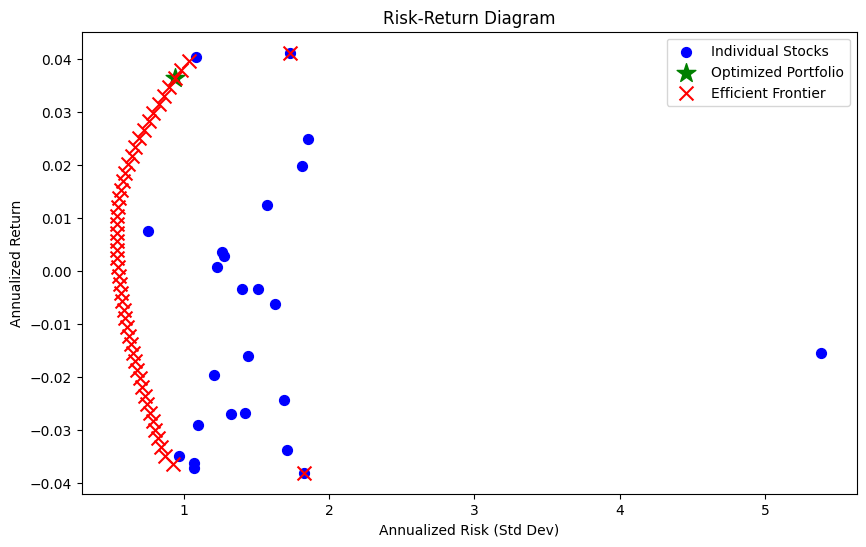

In [ ]:
# Calculate and plot the individual stocks

# Annualizing the standard deviations. Assuming 252 trading days in a year.
# This computes the annualized volatility for each individual stock.
individual_stddevs = np.sqrt(np.diag(cov_matrix)) * np.sqrt(252)

# 'exp_returns' are the expected returns computed using the Fama-French 4-factor model.
# We already annualized the expected returns in the previous step, so we don't need to multiply by 252 again.
annualized_returns = exp_returns

# Assuming 'optimal_weights' is a precomputed set of weights for the optimized portfolio:
# Calculate the annualized return and risk (standard deviation) of the optimized portfolio.
port_return = np.dot(annualized_returns, optimal_weights)
port_stddev = np.sqrt(np.dot(optimal_weights.T, np.dot(cov_matrix * 252, optimal_weights)))

# Initialize a figure for plotting
plt.figure(figsize=(10, 6))

# Plot individual stocks
# This will plot each stock as a blue circle based on its risk (x-axis) and return (y-axis).
plt.scatter(individual_stddevs, annualized_returns, marker='o', color='blue', s=50, label='Individual Stocks')

# Plot the optimized portfolio
# This will plot the optimized portfolio as a green star.
plt.scatter(port_stddev, port_return, marker='*', color='green', s=200, label='Optimized Portfolio')

# Plot the efficient frontier
# This will plot the efficient frontier as a series of red Xs.
# No need to multiply the returns range by 252 since 'returns_range' already represents annualized returns.
plt.scatter([p['fun'] * np.sqrt(252) for p in efficients], returns_range, marker='x', color='red', s=100, label='Efficient Frontier')

# Set the title and axis labels for the plot
plt.title('Risk-Return Diagram')
plt.xlabel('Annualized Risk (Std Dev)')
plt.ylabel('Annualized Return')

# Display the legend to differentiate between individual stocks, optimized portfolio, and efficient frontier.
plt.legend()

# Render the plot
plt.show()
